# Chapter 18 - Gaussian Processes

Any model that is linear in its parameters with a Gaussian distribution over the parameters is a **Gaussian process**. This class spans discrete models, including random walks, and autoregressive processes, as well as continuous models, including Bayesian linear regression models, polynomials, Fourier series, radial basis functions, and even neural networks with an infinite number of hidden units.

## 18.1. Introduction to Gaussian Processes

Unlike the weights of neural networks, which are relatively uninterpretable, the gaussian proceses provide a mechanism for directly reasoning about the high-level properties of functions that could fit the data.

![](../imgs/ch18/gp-observed-data.svg)

Suppose we have a dataset shown in the figure above of regression targets (outputs) $y$ at inputs $x$. To fit the data with a Gaussian process, we start by specifying a *prior distribution* over what types of functions we may believe to be reasonable, some of which are shown in the figure below.

![](../imgs/ch18/gp-sample-prior-functions.svg)

We are not looking for functions that fit the dataset exactly, but rather for specifying reasonable high-level properties of the solutions, such as how quickly they vary with inputs.

Once we condition on data, we can use this prior to infer a *posterior distribution* over functions that could fit the data. The figure below shows some possible posterior functions.

![](../imgs/ch18/gp-sample-posterior-functions.svg)

Each of these posterior functions are entirely consistent with the data, perfectly running through each observation. In order to use these posterior samples to make predictions, we can average the values of every possible sample function from the posterior, to create the blue sruve in the figure below.

![](../imgs/ch18/gp-posterior-samples.svg)

We do not have to take an infinite number of samples to compute this epxectation.

We also want to know how confident we should be in our predictions. Intuitively, we should have more uncertainty where there is more variability in the sample posterior functions, as this tells us there are many more possible values the true function could take. This type of uncertainty is called *epistemic uncertainty*, which is the *reducible uncertainty* associated with lack of information. As we acquire more data, this type of uncertainty disappears, as there will be increasingly fewer solutions consistent with what we observe.

Similar to the posterior mean, we can compute the *posterior variance* in closed form. The shaded region in the figure below shows the two-time posterior standard deviation on either side of the mean, creating a *credible interval* that has a 95% probability of containing the true value of the function for any input $x$.

![](../imgs/ch18/gp-posterior-samples-95.svg)

The properties of the Gaussian process that we fit the data are strongly controlled by the *covariance function*, also known as the *kernel*. The covariance function we used is called the *RBF (Radial Basis Function) kernel*, which has the form
\begin{split}
k_{\textrm{RBF}}(x,x') = \textrm{Cov}(f(x),f(x')) = a^2 \exp\left(-\frac{1}{2\ell^2}||x-x'||^2\right)
\end{split}

The *hyperparameters* of this kernel are interpretable:
* the *amplitude* $a$ controls the vertical scale over which the function is varying. Larger $a$ means larger function values.
* the *length-scale* $\ell$ controls the rate of variation of the function. Larger $\ell$ means the function varies more slowly.

At $||x-x'|| = \ell$, the covariance between a pair of function values is $a^2\exp(-0.5)$. At larger distances than $\ell$, the values of the function values becomes nearly uncorrelated, which means that if we want to make a prediction at a point $x_*$, then function values with input $x$ such that $||x-x_*|| > \ell$ will not have a strong effect on our predictions.

The generalization performance of a Gaussian process will depend on having reasonable values for these hyperparameters. Fortunately, there is a robust and automatic way to specify these hyperparameters, using *maximum likelihood*.

The essense of a Gaussian process states that any collection of function values $f(x_1),\dots,f(x_n)$, indexed by any collection of inputs $x_1,\dots,x_n$, has a joint multivariate Gaussian distribution. The mean vector $\mu$ of this distribution is given by a *mean function*, which is typically taken to be a constant or zero. The covariance matrix of this distribution is given by the *kernel* evaluated at all pairs of the inputs $x$.

\begin{split}
\begin{bmatrix}
f(x) \\f(x_1) \\ \vdots \\ f(x_n) \end{bmatrix}\sim \mathcal{N}\left(\mu, \begin{bmatrix}k(x,x) & k(x, x_1) & \dots & k(x,x_n) \\ k(x_1,x) & k(x_1,x_1) & \dots & k(x_1,x_n) \\ \vdots & \vdots & \ddots & \vdots \\ k(x_n, x) & k(x_n, x_1) & \dots & k(x_n,x_n) 
\end{bmatrix}\right)
\end{split}

This specifies a GP prior. We can compute the conditional distribution of $f(x)$ for any $x$ given $f(x_1),\dots,f(x_n)$, the function values we have observed. This conditional distribution is called the *posterior*, and it is what we use to make predictions.

In particular,
\begin{split}
f(x) | f(x_1), \dots, f(x_n) \sim \mathcal{N}(m,s^2)
\end{split}
where
\begin{aligned}
m &= k(x,x_{1:n}) k(x_{1:n},x_{1:n})^{-1} f(x_{1:n}) \\
s^2 &= k(x,x) - k(x,x_{1:n})k(x_{1:n},x_{1:n})^{-1}k(x,x_{1:n})
\end{aligned}
where $k(x,x_{1:n})$ is a $1\times n$ vector formed by evaluating $k(x, x_i)$ for $i=1,\dots,n$, and $k(x_{1:n},x_{1:n})$ is an $n\times n$ matrix formed by evaluating $k(x_i,x_j)$ for $i,j=1,\dots,n$.

The value $m$ is waht we can use as a point predictor for any $x$, and $s^2$ is what we use for uncertainty: if we want to create an interval with a 95% probability that $f(x)$ is in the interval, we would use $m\pm 2s$.

Suppose we observe a single datapoint, $f(x_1)$ and we want to determine the value of $f(x)$ at some $x$. Because $f(x)$ is described by a Gaussian process, we know the joint distribution over $f(x)$ and $f(x_1)$ is a Gaussian:

\begin{split}
\begin{bmatrix}
f(x) \\
f(x_1) \\
\end{bmatrix}
\sim
\mathcal{N}\left(\mu,
\begin{bmatrix}
k(x,x) & k(x, x_1) \\
k(x_1,x) & k(x_1,x_1)
\end{bmatrix}
\right)\end{split}

The off-diagonal expression $k(x,x_1) = k(x_1, x)$ tells how correlated the function values will be - how strongly determined $f(x)$ will be form $f(x_1)$. If we use a large length-scale $\ell$, relative to $||x-x_1||$, then the function values will be highly correlated.

## 18.2. Gaussian Process Priors

In [1]:
import numpy as np
from scipy.spatial import distance_matrix

from d2l import torch as d2l

d2l.set_figsize()

### 18.2.1. Definition

A Gaussian process is defined as *a collection of random variables, any finite number of which have a joint Gaussian distribution*.

If a function $f(x)$ is a Gaussian process, with *mean function* $m(x)$ and *covariance function* or *kernel* $k(x,x')$, then $f(x) \sim \mathcal{GP}(m, k)$, any collection of function values queried at any collection of input points $x$ has a joint multivariate Gaussian distribution with mean vector $\mu$ and covariance matrix $K$:
\begin{split}
f(x_1),\dots,f(x_n) \sim \mathcal{N}(\mu, K)
\end{split}
where $\mu_i = m(x_i)$ and $K_{ij} = \textrm{Cov}(f(x_i), f(x_j)) = k(x_i, x_j)$.

In other words, any function
\begin{split}
f(x) = w^{\top} \phi(x) = \langle w, \phi(x) \rangle,
\end{split}
with $w$ drawn from a Gaussian distribution, and $\phi$ being any vector of basis functions, for example, $\phi(x) = (1, x, x^2, \dots, x^d)^\top$, is a Gaussian process. 

### 18.2.2. A Simple Gaussian Process

Suppose $f(x) = w_0 + w_1 x$, and $w_0, w_1 \sim \mathcal{N}(0,1)$, with $w_0, w_1, x$ all in one dimension. We can write $f(x)$ as
\begin{split}
f(x) = \begin{bmatrix}w_0, w_1\end{bmatrix}\begin{bmatrix}1 \\ x\end{bmatrix}
\end{split}
where $w = (w_0, w_1)^{\top}$ and $\phi(x) = (1, x)^{\top}$. 

For any $x$, $f(x)$ is a sum of two Gaussian random variables. Since Gaussians are closed under addition, $f(x)$ is also a Gaussian random variable for any $x$. Similarly, the joint distribution for any collection of function values, $(f(x_1),\dots,f(x_n))$, for any collection of inputs $x_1,\dots,x_n$ is a multivariatge Gaussian distribution. Therefore, $f(x)$ is a Gaussian process.

In short, $f(x)$ is a *random function*, or a *distribution over functions*.

In [6]:
def lin_func(x, n_samples):
    preds = np.zeros((n_samples, x.shape[0]))
    for i in range(n_samples):
        w = np.random.normal(0, 1, 2)
        y = w[0] + w[1] * x
        preds[i, :] = y

    return preds

In [7]:
x_points = np.linspace(-5, 5, 50)
outs = lin_func(x_points, 10)
lw_bd = -2 * np.sqrt((1 + x_points **2)) # lower bound
up_bd = 2 * np.sqrt((1 + x_points **2)) # upper bound

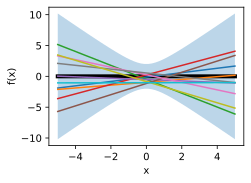

In [8]:
d2l.plt.fill_between(x_points, lw_bd, up_bd, alpha=0.3)
d2l.plt.plot(x_points, np.zeros(len(x_points)), linewidth=4, color='black')
d2l.plt.plot(x_points, outs.T)
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)')
d2l.plt.show()

### 18.2.3. From Weight Space to Function Space

We saw how a distrtibution over parameters in a model induces a distribution over functions above. Since a Gaussian distribution is entirely defined by its first two moments, its mean and covariance matrix, a Gaussian process by extension is defined by its mean function and covariance function.

In the above code snippet, the mean function is given as
\begin{split}
m(x) = E[f(x)] = E[w_0 + w_1x] = E[w_0] + E[w_1]x = 0+0 = 0.
\end{split}
Similarly, the covariance function is given as
\begin{split}
k(x,x') = \textrm{Cov}(f(x),f(x')) = E[f(x)f(x')]-E[f(x)]E[f(x')] = E[w_0^2 + w_0w_1x' + w_1w_0x + w_1^2xx'] = 1 + xx'.
\end{split}
The distribution over functions can now be directly specified and sampled from, without needing to sample from the distribution over parameters.

For example, to draw from $f(x)$, we can form the multivariate Gaussian distribution associated with any collection of $x$ we want to query, and sample from it directly.

### 18.2.4. The Radial Basis Function (RBF) Kernel

The *radial basis function* (RBF) kernel is the most popular covariance function for Gaussian processes and kernel machines in general. This kernel has the form
\begin{split}
k_{\textrm{RBF}}(x,x') = a^2\exp\left(-\frac{1}{2\ell^2}||x-x'||^2\right)
\end{split}
where $a$ is the *amplitude* and $\ell$ is the *length-scale*.

To derive this kernel from weight space, we can consider the function
\begin{split}
f(x) = \sum_{i=1}^J w_i \phi_i(x), w_i  \sim \mathcal{N}\left(0,\frac{\sigma^2}{J}\right), \phi_i(x) = \exp\left(-\frac{(x-c_i)^2}{2\ell^2 }\right).
\end{split}
Here, $f(x)$ is a sum of radial basis functions, with width $\ell$, centered at the points $c_i$.

We can recognize $f(x)$ as having the form $w^{\top} \phi(x)$, where $w=(w_1,\dots,w_J)^{\top}$ and $\phi(x)$ is a vector containing each of the radial basis functions. The covariance function of this Gaussian process is given by
\begin{split}
k(x,x') = \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x').
\end{split}

If we assign $c_J= \log J$, $c_1 = -\log J$, and $c_{i+1}-c_{i} = \Delta c = 2\frac{\log J}{J}$, as $J\rightarrow \infty$, the covariance function becomes the Riemann sum:
\begin{split}
k(x,x') = \lim_{J \to \infty} \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x') = \int_{c_0}^{c_\infty} \phi_c(x)\phi_c(x') dc.
\end{split}
By setting $c_0 = -\infty$ and $c_\infty = \infty$, we spread the infinitely many basis functions across the whole real line, each a distance $\Delta c\rightarrow 0$ apart:
\begin{split}
k(x,x') = \int_{-\infty}^{\infty} \exp(-\frac{(x-c)^2}{2\ell^2}) \exp(-\frac{(x'-c)^2}{2\ell^2 }) dc = \sqrt{\pi}\ell \sigma^2 \exp(-\frac{(x-x')^2}{2(\sqrt{2} \ell)^2}) \propto k_{\textrm{RBF}}(x,x').
\end{split}

By moving into the function space representation, we have derived how to represent a model with an *infinite* number of parameters, using a finite amount of computation. A Gaussian process with an RBF kernel is a *universal approximator*, capable of representing any continuous function to arbitrary precision. So a Gaussian process with an RBF kernel is a model with an infinite number of parameters and much more flexibility than any finite neural network.

The typical pipeline to use a Gaussian process is:
1. Choose the input $x$ points we want to query the GP: $x_1,\dots,x_n$.
2. Evaluate $m(x_i)$, $i=1,\dots,n$, and $k(x_i,x_j)$, $i,j=1,\dots,n$ to respectively form the mean vector and covariance matrix $\mu$ and $K$, where $(f(x_1),\dots,f(x_n)) \sim \mathcal{N}(\mu, K)$.
3. Sample from this multivariate Gaussian distribution to obtain the sample function values.
4. Sample more times to visualize more sample functions queried at those points.

In [9]:
def rbfkernel(x1, x2, ls=4.):
    dist = distance_matrix(
        np.expand_dims(x1, axis=1),
        np.expand_dims(x2, axis=1)
    )
    res = np.exp(-(1. / ls /2) * (dist ** 2))
    return res

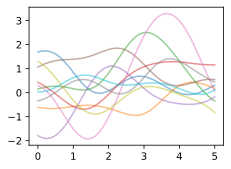

In [11]:
x_points = np.linspace(0, 5, 50)
meanvec = np.zeros(len(x_points))
covmat = rbfkernel(x_points, x_points, ls=1)

prior_samples = np.random.multivariate_normal(meanvec, covmat, size=10)
d2l.plt.plot(x_points, prior_samples.T, alpha=0.5)
d2l.plt.show()

### 18.2.5. The Neural Network Kernel

Consider a neural network function $f(x)$ with one hidden layer:
\begin{split}
f(x) = b + \sum_{i=1}^{J} v_i h(x; u_i),
\end{split}
where $b$ is a bias, $v_i$ are the hidden to output weights, $h$ is any bounded hidden unit transfer function, $u_i$ are the input to hidden weights, and $J$ is the number of hidden units.

Let $b$ and $v_i$ be independent with zero mean and variances $\sigma_b^2$ and $\sigma_v^2$, respectively. Let $u_i$ have independent identical distributions. The central limit theorem shows that any collection of function values $f(x_1),\dots,f(x_n)$ has a joint multivariate Gaussian distribution.

The mean and covariance function of the corresponding Gaussian process are given by
\begin{aligned}
m(x) &= E[f(x)] = 0 \\
k(x,x') &= \textrm{cov}[f(x),f(x')] = E[f(x)f(x')] = \sigma_b^2 + \frac{1}{J} \sum_{i=1}^{J} \sigma_v^2 E[h_i(x; u_i)h_i(x'; u_i)]
\end{aligned}

Let $h(x; u) = \textrm{erf}(u_0 + \sum_{j=1}^{P} u_j x_j)$, where $\textrm{erf}(z) = \frac{2}{\sqrt{\pi}} \int_{0}^{z} e^{-t^2} dt$, and $u \sim \mathcal{N}(0,\Sigma)$. Then,
\begin{split}
k(x,x') = \frac{2}{\pi} \textrm{sin}(\frac{2 \tilde{x}^{\top} \Sigma \tilde{x}'}{\sqrt{(1 + 2 \tilde{x}^{\top} \Sigma \tilde{x})(1 + 2 \tilde{x}'^{\top} \Sigma \tilde{x}')}})
\end{split}

The RBF kernel is  *stationary*, meaning that it is *translation invariant*, and therefore can be written as a function of $\tau=x-x'$.

### 18.3. Gaussian Process Inference

(Waiting for updates)